<a href="https://colab.research.google.com/github/hublun/Bayesian_Aggregation_Average_Data/blob/master/CIFAR10GAN2_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code from:
https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/
How to Develop a GAN to Generate CIFAR10 Small Color Photographs
by Jason Brownlee on July 1, 2019 in Generative Adversarial Networks

and from
https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/

How to Develop a CNN From Scratch for CIFAR-10 Photo Classification
by Jason Brownlee on May 13, 2019 in Deep Learning for Computer Vision

In [2]:
# example of a dcgan on cifar10
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot

# define the standalone discriminator model
def define_discriminator(in_shape=(32,32,3)):
	model = Sequential()
	# normal
	model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 4x4 image
	n_nodes = 256 * 4 * 4
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((4, 4, 256)))
	# upsample to 8x8
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# output layer
	model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

# load and prepare cifar10 training images
def load_real_samples():
	# load cifar10 dataset
	(trainX, _), (_, _) = load_data()
	# convert from unsigned ints to floats
	X = trainX.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i])
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch+1)
	g_model.save(filename)

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=20, n_batch=12):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			if (j+1) % 50 == 0:
				print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
					(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

1/1 [==============================] - 0s 19ms/step
>1, 50/4166, d1=0.483, d2=0.047 g=6.189
1/1 [==============================] - 0s 17ms/step
>1, 100/4166, d1=0.367, d2=0.174 g=4.404
1/1 [==============================] - 0s 18ms/step
>1, 150/4166, d1=0.593, d2=0.557 g=1.373
1/1 [==============================] - 0s 17ms/step
>1, 200/4166, d1=0.742, d2=0.802 g=0.913
1/1 [==============================] - 0s 17ms/step
>1, 250/4166, d1=0.904, d2=0.485 g=2.168
1/1 [==============================] - 0s 18ms/step
>1, 300/4166, d1=0.438, d2=0.292 g=1.696
1/1 [==============================] - 0s 29ms/step
>1, 350/4166, d1=1.033, d2=0.407 g=1.584
1/1 [==============================] - 0s 17ms/step
>1, 400/4166, d1=0.745, d2=0.478 g=1.673
1/1 [==============================] - 0s 35ms/step
>1, 450/4166, d1=0.782, d2=0.698 g=0.847
1/1 [==============================] - 0s 20ms/step
>1, 500/4166, d1=0.609, d2=0.686 g=1.019
1/1 [==============================] - 0s 29ms/step
>1, 550/4166, d1=0.

4/4 [==============================] - 0s 3ms/step


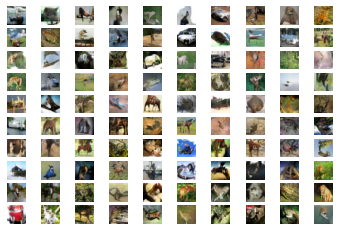

[[0.3126952]]


In [ ]:
# Generation of 100 fake pictures
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# plot the generated images
def create_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

# load model
model = load_model('generator_model_200.h5')
#model = load_model('generator_model_050.h5')
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
create_plot(X, 10)
print(generate_latent_points(1, 1))

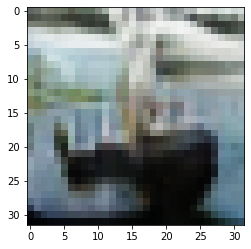

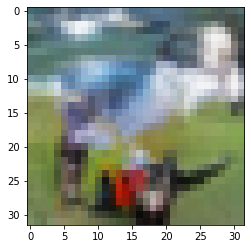

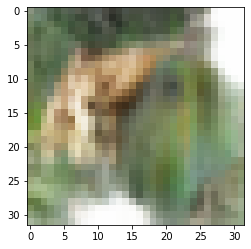

In [ ]:
#Example of plotting the first image of the first three rows, one by one
#plot the result
pyplot.imshow(X[0, :, :])
pyplot.show()
pyplot.imshow(X[10, :, :])
pyplot.show()
pyplot.imshow(X[20, :, :])
pyplot.show()




In [ ]:

# We fit a CIFAR10 CNN classification model and save the final model to a file
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD

# load train and test dataset
def load_dataset():
 # load dataset
 (trainX, trainY), (testX, testY) = cifar10.load_data()
 # one hot encode target values
 trainY = to_categorical(trainY)
 testY = to_categorical(testY)
 return trainX, trainY, testX, testY

# scale pixels
def prep_pixels(train, test):
 # convert from integers to floats
 train_norm = train.astype('float32')
 test_norm = test.astype('float32')
 # normalize to range 0-1
 train_norm = train_norm / 255.0
 test_norm = test_norm / 255.0
 # return normalized images
 return train_norm, test_norm

# define cnn model
def define_model():
 model = Sequential()
 model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
 model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(MaxPooling2D((2, 2)))
 model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(MaxPooling2D((2, 2)))
 model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(MaxPooling2D((2, 2)))
 model.add(Flatten())
 model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
 model.add(Dense(10, activation='softmax'))
 # compile model
 opt = SGD(lr=0.001, momentum=0.9)
 model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
 return model

# run the test harness for evaluating a model
def run_test_harness():
 # load dataset
 trainX, trainY, testX, testY = load_dataset()
 # prepare pixel data
 trainX, testX = prep_pixels(trainX, testX)
 # define model
 model = define_model()
 # fit model
 model.fit(trainX, trainY, epochs=100, batch_size=64, verbose=1)
 # save model
 model.save('final_model.h5')

# entry point, run the test harness
run_test_harness()

Epoch 1/100
782/782 [==============================] - 4s 5ms/step - loss: 1.7399 - accuracy: 0.3668
Epoch 2/100
782/782 [==============================] - 4s 5ms/step - loss: 1.4068 - accuracy: 0.4918
Epoch 3/100
782/782 [==============================] - 4s 5ms/step - loss: 1.2352 - accuracy: 0.5614
Epoch 4/100
782/782 [==============================] - 4s 5ms/step - loss: 1.1102 - accuracy: 0.6081
Epoch 5/100
782/782 [==============================] - 4s 5ms/step - loss: 1.0107 - accuracy: 0.6424
Epoch 6/100
782/782 [==============================] - 4s 5ms/step - loss: 0.9290 - accuracy: 0.6738
Epoch 7/100
782/782 [==============================] - 4s 5ms/step - loss: 0.8608 - accuracy: 0.6996
Epoch 8/100
782/782 [==============================] - 4s 5ms/step - loss: 0.7972 - accuracy: 0.7212
Epoch 9/100
782/782 [==============================] - 4s 5ms/step - loss: 0.7371 - accuracy: 0.7428
Epoch 10/100
782/782 [==============================] - 4s 5ms/step - loss: 0.6855 - accura

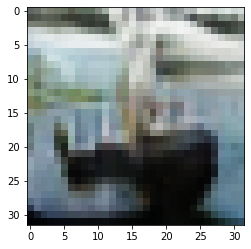

1/1 [==============================] - 0s 92ms/step
[[1.3119150e-23 2.8293397e-29 3.5499173e-33 6.4830292e-27 1.4830736e-20
  9.5360775e-28 2.8871971e-25 4.4750572e-24 1.0000000e+00 8.2622558e-16]]
1/1 [==============================] - 0s 18ms/step
Ship


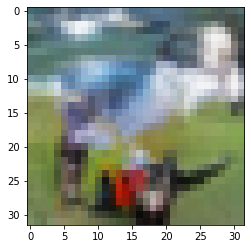

1/1 [==============================] - 0s 18ms/step
Bird


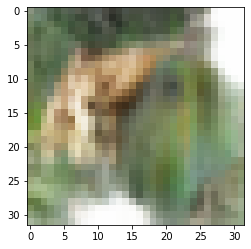

1/1 [==============================] - 0s 19ms/step
Bird


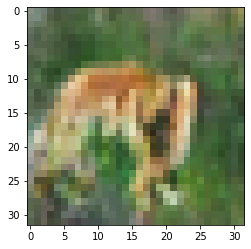

1/1 [==============================] - 0s 18ms/step
Deer


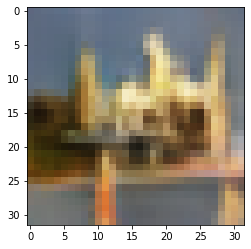

1/1 [==============================] - 0s 19ms/step
Dog


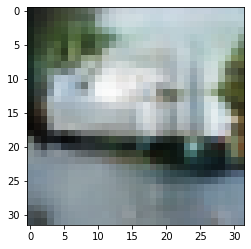

1/1 [==============================] - 0s 18ms/step
Truck


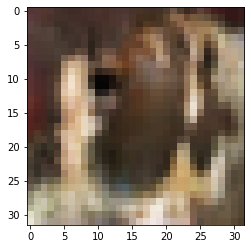

1/1 [==============================] - 0s 18ms/step
Dog


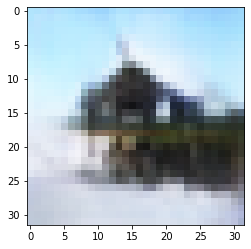

1/1 [==============================] - 0s 18ms/step
Airplane


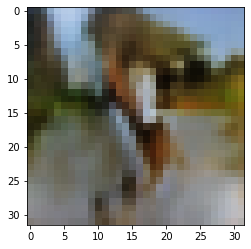

1/1 [==============================] - 0s 19ms/step
Cat


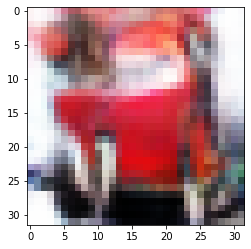

1/1 [==============================] - 0s 18ms/step
Automobile


In [ ]:
#Testing the fake pictures
#We load the fitted CIFAR10 classification model and
#see what classes are predicted by the GAN generated images for the first image of the ten rows
import numpy as np
class_names =['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
cifar10_model = load_model('final_model.h5')
pyplot.imshow(X[0, :, :])
pyplot.show()
#Here we show the actual predicted class values for the ten possible categories.
print(cifar10_model.predict(X[0, :, :].reshape((1,32,32,3))))
print(class_names[np.argmax(cifar10_model.predict(X[0, :, :].reshape((1,32,32,3))))])
pyplot.imshow(X[10, :, :])
pyplot.show()
print(class_names[np.argmax(cifar10_model.predict(X[10, :, :].reshape((1,32,32,3))))])
pyplot.imshow(X[20, :, :])
pyplot.show()
print(class_names[np.argmax(cifar10_model.predict(X[20, :, :].reshape((1,32,32,3))))])
pyplot.imshow(X[30, :, :])
pyplot.show()
print(class_names[np.argmax(cifar10_model.predict(X[30, :, :].reshape((1,32,32,3))))])
pyplot.imshow(X[40, :, :])
pyplot.show()
print(class_names[np.argmax(cifar10_model.predict(X[40, :, :].reshape((1,32,32,3))))])
pyplot.imshow(X[50, :, :])
pyplot.show()
print(class_names[np.argmax(cifar10_model.predict(X[50, :, :].reshape((1,32,32,3))))])
pyplot.imshow(X[60, :, :])
pyplot.show()
print(class_names[np.argmax(cifar10_model.predict(X[60, :, :].reshape((1,32,32,3))))])
pyplot.imshow(X[70, :, :])
pyplot.show()
print(class_names[np.argmax(cifar10_model.predict(X[70, :, :].reshape((1,32,32,3))))])
pyplot.imshow(X[80, :, :])
pyplot.show()
print(class_names[np.argmax(cifar10_model.predict(X[80, :, :].reshape((1,32,32,3))))])
pyplot.imshow(X[90, :, :])
pyplot.show()
print(class_names[np.argmax(cifar10_model.predict(X[90, :, :].reshape((1,32,32,3))))])
